#### Assignment 3 - Alex Ceccotti - 790497

In [1]:
import os
from matplotlib import pyplot as plt
from time import time
from skimage import feature
from keras.preprocessing import image as kimage
from keras.applications import mobilenet_v2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

Using TensorFlow backend.


Carico la rete neurale MobileNetV2 togliendo gli strati fully connected.

In [2]:
net = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='max')

C:\Users\alexc\Anaconda3\envs\dsim\lib\site-packages\keras_applications\mobilenet_v2.py:306: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Definisco la funzione "load_data" in modo da caricare le immagini con delle label associate. In realtà, tramite la funzione "mobilenet_features" vengono caricate le feature estratte con MobileNetV2. Viene infine fatto lo split in train e test set.

In [3]:
def load_data(feature_extractor, directory, maximages=-1, ext='.jpg'):
    base_path = './'+directory+'/'
    labels = []
    features = []
    for di,d in enumerate(sorted(os.listdir(base_path))):
        for fi,f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            if f.endswith(ext) and (fi<maximages or maximages==-1):
                image = kimage.load_img(base_path + d + '/' + f, target_size=(224, 224))
                cur_features = feature_extractor(image)
                features.append(cur_features)
                labels.append(di)
        print("Caricate " + str(fi+1) + " immagini dalla cartella numero " + str(di) + " (" + d + ")")
        fi = -1
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=1)
    return X_train, X_test, y_train, y_test

In [4]:
def mobilenet_features(img):
    x = kimage.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = mobilenet_v2.preprocess_input(x)
    f = net.predict(x)
    return f.flatten()

In [5]:
t0 = time()
X_train, X_test, y_train, y_test=load_data(feature_extractor=mobilenet_features, directory="classes")
print("Caricamento in  %0.3f secondi" %(time() - t0))

Caricate 500 immagini dalla cartella numero 0 (cat500)
Caricate 500 immagini dalla cartella numero 1 (dog500)
Caricamento in  212.128 secondi


In [6]:
X_train[6].shape

(1280,)

Vengono caricate 500 immagini di cani e 500 immagini di gatti. Ad ogni immagine sono associate 1280 features. Bisogna ora procedere con la normalizzazione. Viene infine fatto un dump del train e del test set con le features normalizzate in modo da non dover rifare ogni volta tutto il processo di estrazione delle features.

In [7]:
X_train_stack = np.array([])
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))
eps = 0.001
X_train_mean = X_train_stack.mean()
X_train_std = X_train_stack.std()
X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]

In [8]:
joblib.dump([X_train, X_test, y_train, y_test], 'feat_data.joblib')

['feat_data.joblib']

A partire dalle feature normalizzate viene allenata una SVM.

In [9]:
param_grid = {'C': [0.1, 0.5, 1, 1.5, 2, 5],
          'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)

t2 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t2))

print("Migliore combinazione di parametri:")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

Addestramento completato in 127.339s
Migliore combinazione di parametri:
 C: 1
 gamma: 0.0001


I parametri ottimali sono C=1 e gamma=0.0001. Il report di classificazione sul test set è il seguente.

In [10]:
y_pred = clf.predict(X_test)

print("Report di classificazione:")
print(classification_report(y_test, y_pred))

Report di classificazione:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       149
           1       0.98      0.99      0.99       151

   micro avg       0.99      0.99      0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [11]:
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("Accuracy: " + str(accuracy_score(y_test, y_pred)))

Matrice di confusione:
[[146   3]
 [  1 150]]
Accuracy: 0.987


Si ottengono valori alti sia di F1 (0.99) sia di accuracy (0.987).

###### problema a scelta: icons

Viene applicato lo stesso procedimento ad un dataset in cui sono presenti 50 classi. <br> Il dataset è scaricabile al seguente link: https://www.kaggle.com/danhendrycks/icons50 <br> Le immagini del dataset sono delle icone.

In [15]:
t0 = time()
X_train, X_test, y_train, y_test=load_data(feature_extractor=mobilenet_features, directory="Icons-50", maximages=-1, ext='.png')
print("Caricamento in  %0.3f secondi" %(time() - t0))

Caricate 76 immagini dalla cartella numero 0 (airplane)
Caricate 392 immagini dalla cartella numero 1 (arrow_directions)
Caricate 192 immagini dalla cartella numero 2 (ball)
Caricate 100 immagini dalla cartella numero 3 (biking)
Caricate 229 immagini dalla cartella numero 4 (bird)
Caricate 90 immagini dalla cartella numero 5 (blade)
Caricate 289 immagini dalla cartella numero 6 (boat)
Caricate 208 immagini dalla cartella numero 7 (books)
Caricate 312 immagini dalla cartella numero 8 (building)
Caricate 160 immagini dalla cartella numero 9 (bunny_ears)
Caricate 105 immagini dalla cartella numero 10 (cartwheeling)
Caricate 417 immagini dalla cartella numero 11 (clock)
Caricate 141 immagini dalla cartella numero 12 (cloud)
Caricate 63 immagini dalla cartella numero 13 (disk)
Caricate 238 immagini dalla cartella numero 14 (drinks)
Caricate 429 immagini dalla cartella numero 15 (emotion_face)
Caricate 119 immagini dalla cartella numero 16 (envelope)
Caricate 455 immagini dalla cartella nume

In [16]:
X_train_stack = np.array([])
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))
eps = 0.001
X_train_mean = X_train_stack.mean()
X_train_std = X_train_stack.std()
X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]

Per gli stessi motivi esposti precedentemente, si effettua un dump del train e del test set.

In [17]:
joblib.dump([X_train, X_test, y_train, y_test], 'icons_data.joblib')

['icons_data.joblib']

Viene allenata una SVM.

In [19]:
param_grid = {'C': [1, 5, 10, 50, 100, 500],
          'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)

t2 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t2))

print("Migliore combinazione di parametri:")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

C:\Users\alexc\Anaconda3\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Addestramento completato in 18270.966s
Migliore combinazione di parametri:
 C: 50
 gamma: 0.0001


I parametri ottimali sono C=50 e gamma=0.0001. Il report di classificazione è il seguente.

In [30]:
y_pred = clf.predict(X_test)

print("Report di classificazione:")
print(classification_report(y_test, y_pred))

Report di classificazione:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       0.94      0.98      0.96       121
           2       0.97      0.92      0.94        61
           3       1.00      1.00      1.00        29
           4       0.85      0.90      0.88        70
           5       1.00      0.83      0.90        23
           6       0.95      0.99      0.97        90
           7       1.00      0.95      0.97        61
           8       0.95      0.95      0.95        81
           9       1.00      0.97      0.98        58
          10       1.00      1.00      1.00        30
          11       0.98      1.00      0.99       131
          12       0.96      0.94      0.95        51
          13       1.00      0.94      0.97        16
          14       0.94      0.94      0.94        71
          15       0.97      1.00      0.99       114
          16       1.00      0.86      0.92        28


Matrice di confusione:


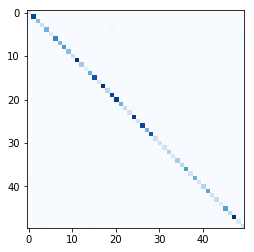

In [31]:
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap='Blues')

In [32]:
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))

Accuracy: 0.965


Si ottiene un F1-score pari a 0.96 e un accuaracy pari a 0.965.